In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TrainingArguments, Trainer
import torch
from torch import nn
from transformers import AutoModel, AutoConfig
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2024-09-09 09:23:53.613914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 09:23:53.613986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 09:23:53.615542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 09:23:53.625699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 09:23:55.010955: W tensorflow/compiler/tf2

In [3]:
# Load the data
data = pd.read_csv("dataset_Sep_9_masked.csv", sep=",", engine="python")

# Prepare the data
sentences = data['text'].values
labels = data['Ποικιλία'].values

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [5]:

# Convert encoded labels into a Pandas Series to use .value_counts()
label_distribution = pd.Series(encoded_labels).value_counts()

# Print the distribution of each label
print("Label distribution:")
print(label_distribution)

# Optionally, you can also map back the encoded values to their original labels:
decoded_labels = label_encoder.inverse_transform(label_distribution.index)
distribution_with_labels = pd.DataFrame({'Label': decoded_labels, 'Count': label_distribution.values})

print("\nDistribution of each label:")
print(distribution_with_labels)

Label distribution:
3    1042
2     487
1     477
0     306
Name: count, dtype: int64

Distribution of each label:
   Label  Count
0      3   1042
1      2    487
2      1    477
3      0    306


In [6]:
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(sentences, encoded_labels, 
                                                                              test_size=0.3, random_state=42, stratify=encoded_labels)
val_sentences, dev_sentences, val_labels, dev_labels = train_test_split(temp_sentences, temp_labels,
                                                                        test_size=0.5, random_state=42, stratify=temp_labels)

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

In [7]:
def print_label_distribution(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} set label distribution:")
    for label, count in zip(unique, counts):
        print(f"Label {label}: {count}")

print_label_distribution(train_labels, "Training")
print_label_distribution(val_labels, "Validation")
print_label_distribution(dev_labels, "Dev")


Training set label distribution:
Label 0: 214
Label 1: 334
Label 2: 341
Label 3: 729

Validation set label distribution:
Label 0: 46
Label 1: 71
Label 2: 73
Label 3: 157

Dev set label distribution:
Label 0: 46
Label 1: 72
Label 2: 73
Label 3: 156


In [8]:
# Function to count sequences longer than 512 tokens
def count_long_sequences(sentences, tokenizer):
    count = 0
    for sentence in sentences:
        tokens = tokenizer.encode(sentence, add_special_tokens=True)
        if len(tokens) > 512:
            count += 1
    return count

# Count and print long sequences in training and validation sets
train_long_count = count_long_sequences(train_sentences, tokenizer)
val_long_count = count_long_sequences(val_sentences, tokenizer)

print(f"Number of training sequences longer than 512 tokens: {train_long_count} out of {len(train_sentences)}")
print(f"Number of validation sequences longer than 512 tokens: {val_long_count} out of {len(val_sentences)}")

Number of training sequences longer than 512 tokens: 39 out of 1618
Number of validation sequences longer than 512 tokens: 8 out of 347


In [9]:
max_length = 512
train_encodings = tokenizer(train_sentences.tolist(), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_sentences.tolist(), truncation=True, padding=True, max_length=max_length)
dev_encodings = tokenizer(dev_sentences.tolist(), truncation=True, padding=True, max_length=max_length)

In [10]:
class BertForSequenceClassification(nn.Module):
    def __init__(self, model_name_or_path, num_labels=4):
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.config = AutoConfig.from_pretrained(model_name_or_path)
        self.bert = AutoModel.from_pretrained(model_name_or_path, config=self.config)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            #nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels),
        )
        self.init_weights()

    def init_weights(self):
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooler_output = outputs.pooler_output
        logits = self.classifier(pooler_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else logits

    def save_pretrained(self, save_directory):
        os.makedirs(save_directory, exist_ok=True)
        self.config.save_pretrained(save_directory)
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def from_pretrained(cls, save_directory, model_name_or_path, num_labels=4):
        config = AutoConfig.from_pretrained(save_directory)
        model = cls(model_name_or_path, num_labels=num_labels)
        state_dict = torch.load(os.path.join(save_directory, "pytorch_model.bin"), map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        return model

In [11]:
class GreekSentencesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GreekSentencesDataset(train_encodings, train_labels)
val_dataset = GreekSentencesDataset(val_encodings, val_labels)
dev_dataset = GreekSentencesDataset(dev_encodings, dev_labels)

In [12]:
model_name_or_path = "nlpaueb/bert-base-greek-uncased-v1"
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification(model_name_or_path, num_labels)

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

In [13]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=20,
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    report_to = "none",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [14]:
# Train the model
train_result = trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()

# Print training and evaluation results
print(f"Training Loss: {train_result.metrics['train_loss']:.4f}")
print(f"Evaluation Loss: {eval_result['eval_loss']:.4f}")


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.157800,0.144467,0.948127,0.946754,0.948602,0.948127


Training Loss: 0.4765
Evaluation Loss: 0.1445


In [15]:
# Save the model and tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [16]:
print(f"Training Loss: {train_result.metrics['train_loss']:.4f}")
print(f"Validation Loss: {eval_result['eval_loss']:.4f}")
print(f"Validation Accuracy: {eval_result['eval_accuracy']:.4f}")
print(f"Validation F1 Score: {eval_result['eval_f1']:.4f}")

# Evaluate on dev set
dev_pred = trainer.predict(dev_dataset)
dev_preds = dev_pred.predictions.argmax(-1)
dev_labels = dev_dataset.labels

dev_accuracy = accuracy_score(dev_labels, dev_preds)
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(dev_labels, dev_preds, average='weighted')

print("\nDev Set Evaluation:")
print(f"Accuracy: {dev_accuracy:.4f}")
print(f"Precision: {dev_precision:.4f}")
print(f"Recall: {dev_recall:.4f}")
print(f"F1 Score: {dev_f1:.4f}")

Training Loss: 0.4765
Validation Loss: 0.1445
Validation Accuracy: 0.9481
Validation F1 Score: 0.9468

Dev Set Evaluation:
Accuracy: 0.9481
Precision: 0.9477
Recall: 0.9481
F1 Score: 0.9478



Classification Report:
                      precision    recall  f1-score   support

αρχαία/προμεσαιωνική       0.98      0.98      0.98        46
     κνε/λογοτεχνικό       0.91      0.88      0.90        73
            δημοτική       0.94      0.95      0.95       156
         καθαρεύουσα       0.97      1.00      0.99        72

            accuracy                           0.95       347
           macro avg       0.95      0.95      0.95       347
        weighted avg       0.95      0.95      0.95       347



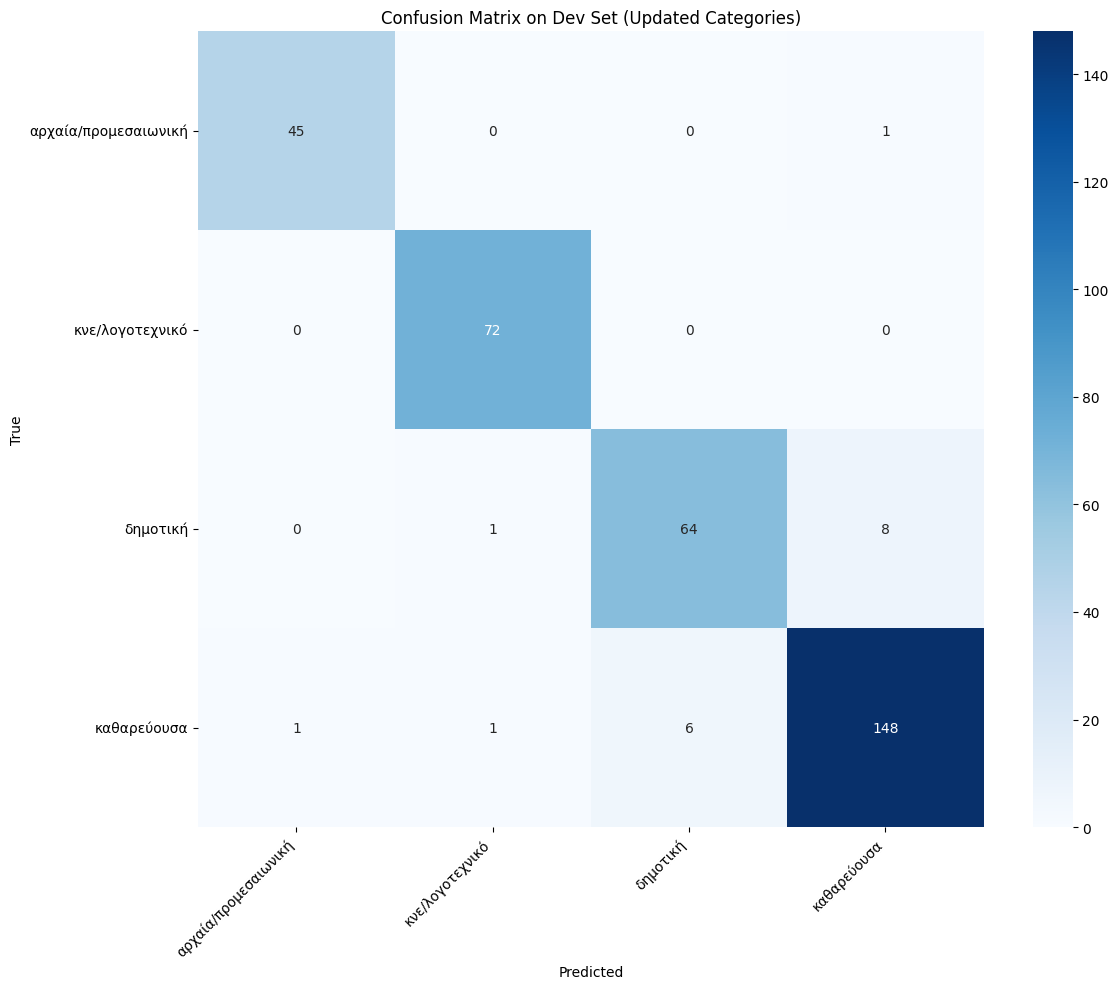

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Define the new category map
new_category_map = {
    0: 'αρχαία/προμεσαιωνική',
    1: 'κνε/λογοτεχνικό',
    2: 'δημοτική',
    3: 'καθαρεύουσα'
}

# Function to map old labels to new labels
def map_to_new_category(label):
    if label in [0, 5]:  # 'αρχαία' or 'προμεσαιωνική'
        return 0
    elif label in [1, 4]:  # 'κνε' or 'λογοτεχνικό'
        return 1
    else:
        return label

# Convert numeric labels to new numeric labels
dev_labels_new = [map_to_new_category(label) for label in dev_labels]
dev_preds_new = [map_to_new_category(pred) for pred in dev_preds]

# Convert new numeric labels to string labels
dev_labels_str = [new_category_map[label] for label in dev_labels_new]
dev_preds_str = [new_category_map[pred] for pred in dev_preds_new]

# Create confusion matrix
cm = confusion_matrix(dev_labels_str, dev_preds_str, labels=list(new_category_map.values()))

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(new_category_map.values()),
            yticklabels=list(new_category_map.values()))
plt.title('Confusion Matrix on Dev Set (Updated Categories)')
plt.xlabel('Predicted')
plt.ylabel('True')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the figure
plt.savefig('./confusion_matrix_updated.png')

# Print classification report
print("\nClassification Report:")
print(classification_report(dev_labels_str, dev_preds_str, target_names=list(new_category_map.values())))

In [18]:
# Identify the misclassified elements
misclassified_indices = [i for i, (true, pred) in enumerate(zip(dev_labels_new, dev_preds_new)) if true != pred]

# Retrieve the true labels, predicted labels, and corresponding text for misclassified elements
misclassified_samples = [(i, dev_sentences[i], dev_labels_new[i], dev_preds_new[i]) for i in misclassified_indices]

# Print out the misclassified samples with their corresponding text, true labels, and predicted labels
print("Misclassified Samples:")
for index, text, true_label, pred_label in misclassified_samples:
    true_str = new_category_map[true_label]
    pred_str = new_category_map[pred_label]
    print(f"Index: {index}\nText: {text}\nTrue Label: {true_str}\nPredicted Label: {pred_str}\n")


Misclassified Samples:
Index: 5
Text: Μετά δε ταύτα, επειδή οι Σπαρτιάται διά μεν των λόγων προσεφέροντο ως φίλοι και σύμμαχοι των Θηβαίων, πραγματικώς δ υπέβλεπον της πόλεως το φρόνημα και την δύναμιν, και προ πάντων εμίσουν την εταιρίαν του Ισμηνίου και Ανδροκλείδου, εις ήν ανήκε και ο Πελοπίδας, και ήτις εφαίνετο φιλελεύθερος συγχρόνως και δημοτική, ο Αρχίας, και ο Λεοντίδας και ο Φίλιππος, άνδρες ολιγαρχικοί και πλούσιοι, και ξένοι προς πάσαν μετριοφροσύνην, καταπείθουσι Φοιβίδαν τον Λάκωνα, όστις μετά στρατεύματος διήρχετο την χώραν, να καταλάβη εξαίφνης την Καδμείαν και εκδιώξας τους εναντιουμένους, να καταστήση την πολιτείαν υπήκοον των Λακεδαιμονίων. Πεισθείς λοιπόν εκείνος, επετέθη, εν ώ οι Θηβαίοι δεν τον περιέμενον, επί της εορτής των Θεσμοφορίων, και εκυρίευσε την ακρόπολιν. Αρπαγείς δ ο Ισμηνίας, και κομισθείς εις την Λακεδαίμονα, μετ ολίγον καιρόν εφονεύθη· ο δε Πελοπίδας και ο Φερένικος και ο Ανδροκλείδας, μετά πολλών άλλων φεύγοντες, απεκηρύχθησαν. Ο δ Επαμινώνδας έμειν

In [19]:
# Save additional training information
with open("./saved_model/training_info.txt", "w") as f:
    f.write(f"Total training steps: {trainer.state.global_step}\n")
    f.write(f"Training Loss: {train_result.metrics['train_loss']:.4f}\n")
    f.write(f"Validation Loss: {eval_result['eval_loss']:.4f}\n")
    f.write(f"Validation Accuracy: {eval_result['eval_accuracy']:.4f}\n")
    f.write(f"Dev Set Accuracy: {dev_accuracy:.4f}\n")
    f.write(f"Dev Set F1 Score: {dev_f1:.4f}\n")

print("\nTraining completed. Model saved and evaluation results recorded.")


Training completed. Model saved and evaluation results recorded.


In [20]:
import pandas as pd
import torch
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader

In [21]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Load the dataset
df = pd.read_csv("../pca/twok_predicted_masked.csv")

loaded_model = BertForSequenceClassification.from_pretrained("./saved_model", model_name_or_path="nlpaueb/bert-base-greek-uncased-v1")
loaded_model.to(device)  # Move the model to GPU if available
loaded_tokenizer = AutoTokenizer.from_pretrained("./saved_model")

In [23]:
# Tokenize all texts
encodings = loaded_tokenizer(df['text'].tolist(), truncation=True, padding=True, max_length=512)
dataset = TensorDataset(torch.tensor(encodings['input_ids']), 
                        torch.tensor(encodings['attention_mask']))
dataloader = DataLoader(dataset, batch_size=32)  # Adjust batch size as needed

# Make predictions
loaded_model.eval()
predictions = []

In [24]:
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask = [b.to(device) for b in batch]
        outputs = loaded_model(input_ids, attention_mask=attention_mask)
        logits = outputs
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

In [25]:
# Define category mapping
category_map = {
    0: 'αρχαία/προμεσαιωνική',
    1: 'κνε/λογοτεχνικό',
    2: 'δημοτική',
    3: 'καθαρεύουσα'
}

In [26]:
# Create results DataFrame
results_df = pd.DataFrame({
    'text': df['text'],
    'mask': df['mask'],
    'ποικιλία': [category_map[pred] if mask == 1 else "---" for pred, mask in zip(predictions, df['mask'])]
})

In [27]:
# Save results
results_df.to_csv("twok_classified.csv", index=False)

print(f"Processed {len(df)} rows.")
print("Results saved to 'predictions_with_greek_categories.csv'")

Processed 2000 rows.
Results saved to 'predictions_with_greek_categories.csv'
